In [29]:
from construct_eq_fpr_df import construct_df_for_eq_div_fpr
from get_data_compas import get_recid_compas_df
from get_data_compas import get_compas_fpr_tpr
from construct_eq_fpr_df import get_fpr_eq_div
from onehalfthreshold import get_optimal_fp_tp
from onehalfthreshold import get_indices_for_a_opt
from onehalfthreshold import get_fpa_opt_tpa_opt_thres_a_opt
from matplotlib.font_manager import FontProperties
import matplotlib.pylab as plt 

In [17]:
#list of attributes are White, Black 
recid_w_b_df = get_recid_compas_df()
fpr_df, tpr_df = get_compas_fpr_tpr(recid_w_b_df)

data_fpr_Black = fpr_df['Black']
data_tpr_Black = tpr_df['Black']

data_fpr_White = fpr_df['White']
data_tpr_White = tpr_df['White']

In [18]:
eq_fpr_df = construct_df_for_eq_div_fpr(fpr_df,tpr_df)
print(eq_fpr_df)

Index(['Black', 'White'], dtype='object')
      Black_tpr Black_threshold  White_tpr White_threshold
0.00          0              11          0              11
0.01  0.0358435         10.6868  0.0356282         10.2061
0.02   0.071687         10.3736  0.0694372         9.63517
0.03    0.10753         10.0604   0.102608         9.14241
0.04   0.132378         9.86863    0.14264         8.63714
...         ...             ...        ...             ...
0.95    0.98632         1.27852    0.97963         1.13558
0.96   0.989056         1.22282   0.983704         1.10846
0.97   0.991792         1.16711   0.987778         1.08135
0.98   0.994528         1.11141   0.991852         1.05423
0.99   0.997264          1.0557   0.995926         1.02712

[100 rows x 4 columns]


In [19]:
drop_thresholds_df = eq_fpr_df.drop(columns = ['Black_threshold','White_threshold'])
print(drop_thresholds_df)

      Black_tpr  White_tpr
0.00          0          0
0.01  0.0358435  0.0356282
0.02   0.071687  0.0694372
0.03    0.10753   0.102608
0.04   0.132378    0.14264
...         ...        ...
0.95    0.98632    0.97963
0.96   0.989056   0.983704
0.97   0.991792   0.987778
0.98   0.994528   0.991852
0.99   0.997264   0.995926

[100 rows x 2 columns]


In [20]:
pointwise_min_df = drop_thresholds_df.min(axis=1)
print(pointwise_min_df)

0.00    0.000000
0.01    0.035628
0.02    0.069437
0.03    0.102608
0.04    0.132378
          ...   
0.95    0.979630
0.96    0.983704
0.97    0.987778
0.98    0.991852
0.99    0.995926
Length: 100, dtype: float64


In [21]:
eq_fpr = list(get_fpr_eq_div())
min_tpr = list(pointwise_min_df)

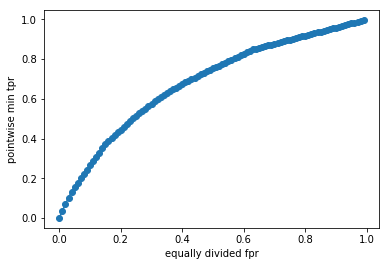

In [22]:
plt.plot(eq_fpr,min_tpr,'-o')
plt.xlabel('equally divided fpr')
plt.ylabel('pointwise min tpr')
plt.show()

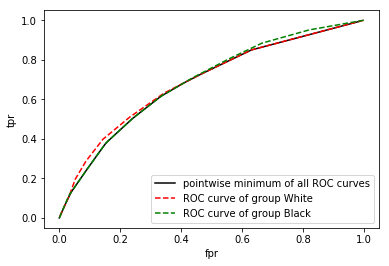

In [31]:
plt.plot(eq_fpr,min_tpr,'k',label='pointwise minimum of all ROC curves')
plt.plot(data_fpr_White, data_tpr_White,'--r',label='ROC curve of group White')
plt.plot(data_fpr_Black,data_tpr_Black,'--g',label='ROC curve of group Black')

plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [30]:
#Showing opt for a particular loss function ration 
loss_fn,loss_fp = 0.3,0.2 #cost of a non-defaulter not getting a loan, cost of a defaulter getting a loan
opt_fp, opt_tp = get_optimal_fp_tp(loss_fn,loss_fp,pointwise_min_df,eq_fpr)
print('optimal fp:', opt_fp)
print('optimal tp:', opt_tp)

optimal fp: 0.63
optimal tp: 0.8488621331128565


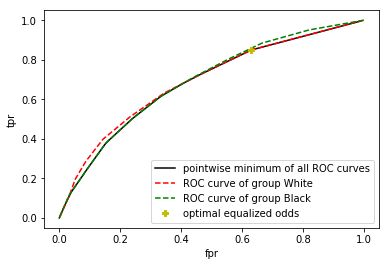

In [32]:
plt.plot(eq_fpr,min_tpr,'k',label='pointwise minimum of all ROC curves')
plt.plot(data_fpr_White, data_tpr_White,'--r',label='ROC curve of group White')
plt.plot(data_fpr_Black,data_tpr_Black,'--g',label='ROC curve of group Black')
plt.plot(opt_fp,opt_tp,'Py',label = 'optimal equalized odds')
plt.legend()

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

In [33]:
opt_slope = opt_tp/opt_fp
list_attrs = ['White','Black']
for attr in list_attrs: 
    tp_attr_list = list(eq_fpr_df[attr+'_tpr'])
    found_index_1, found_index_2 = get_indices_for_a_opt(opt_slope,eq_fpr,tp_attr_list,0,len(eq_fpr)-1)
    #print(found_index_1)
    #print(found_index_2)
    threshold_attr_list = list(eq_fpr_df[attr+'_threshold'])
    fpr_1 = eq_fpr[found_index_1]
    fpr_2 = eq_fpr[found_index_2]
    tpr_1 = tp_attr_list[found_index_1]
    tpr_2 = tp_attr_list[found_index_2]
    threshold_1 = threshold_attr_list[found_index_1]
    threshold_2 = threshold_attr_list[found_index_2]
    fpa_opt,tpa_opt,threshold_a_opt = get_fpa_opt_tpa_opt_thres_a_opt(fpr_1,fpr_2,tpr_1,tpr_2,threshold_1,threshold_2,opt_slope)
    p_a = opt_fp/fpa_opt #=opt_tp/tpa_opt
    print('Opt false positive for group '+attr+':',fpa_opt)
    print('Opt true positive for group '+attr+':',tpa_opt)
    print('Opt threshold for group '+attr+':',threshold_a_opt)
    print('Opt probablity p_a group '+attr+':',p_a)

Opt false positive for group White: 0.63
Opt true positive for group White: 0.8488621331128565
Opt threshold for group White: 2.007330508474576
Opt probablity p_a group White: 1.0
Opt false positive for group Black: 0.6447269719325708
Opt true positive for group Black: 0.8687052582064679
Opt threshold for group Black: 3.190951794461167
Opt probablity p_a group Black: 0.977157816294816
